In [1]:
import pylab
import h5py
import math
import array
from numpy import *
import numpy as np
from pycbc.types import TimeSeries, FrequencySeries
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc import types, fft, waveform
import lal
from scipy import interpolate
from scipy.interpolate import interp1d
from lal import MSUN_SI, MTSUN_SI, G_SI, PC_SI, C_SI, PI
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 200
#plt.rcParams["font.family"] = "monospace"
 
from matplotlib import gridspec

import matplotlib.pyplot as plt


In [ ]:


import numpy as np
from pyseobnr.generate_waveform import GenerateWaveform
import matplotlib.pyplot as plt
# Start with the usual parameter definitions
# Masses in solar masses
m1 = 20.0
m2 = 20.0
s1x, s1y, s1z = 0.0, 0.0, 0.0
s2x, s2y, s2z = 0.0, 0.0, 0.0

deltaT = 1.0 / 4096.0
f_min = 20.0
f_max = 1024.0

distance = 1# Mpc
inclination = 0 # np.pi / 3.0
phiRef = 0.0
approximant = "SEOBNRv5HM"

params_dict = {
    "mass1": m1,
    "mass2": m2,
    "spin1x": s1x,
    "spin1y": s1y,
    "spin1z": s1z,
    "spin2x": s2x,
    "spin2y": s2y,
    "spin2z": s2z,
    "deltaT": deltaT,
    "f22_start": f_min,
    #"phi_ref": phiRef,
    "distance": distance,
    "inclination": inclination,
    #"f_max": f_max,
    "approximant": approximant,
}

# We call the generator with the parameters
wfm_gen = GenerateWaveform(params_dict)
# Generate mode dictionary
times, hlm = wfm_gen.generate_td_modes()

In [ ]:
plt.figure()
plt.plot(times, abs(hlm[(2,2)]))
plt.show()

### Hybrid Mismatches 

In [2]:
hyb = ['1355','1356','1357','1358','1359','1360','1361','1362','1363','1364','1365','1366','1367','1368','1369','1370','1371','1372','1373','1374']

In [3]:
def Hyb_match(ID,m,delta_t):
    f = h5py.File('/home/pratul/Downloads/Project/New hybrids/'+ID+'_EccTD_22_hyb_poster.h5','r')
    f1 = h5py.File('/home/pratul/Downloads/Project/hybrids/'+ID+'hyb_EccTD_xlow045_GM.h5','r')
    d = f['l2_m2']
    d1 = f1['l2_m2']
    #d = f['OutermostExtraction.dir']['Y_l2_m2.dat']
    #x1 = np.real(d[:,0])
    #plotband=np.where(x1>=170)
    tVec = real(d[:,0])
    h22pVec = real(d[0:,1])
    h22cVec = real(d[0:,2])

    tVec1 = real(d1[:,0])
    h22pVec1 = real(d1[0:,1])
    h22cVec1 = real(d1[0:,2])

    mode2polfac=4*(5/(64*np.pi))**(1/2)
    hpVec=h22pVec
    hcVec=h22cVec

    hpVec1=h22pVec1
    hcVec1=h22cVec1

    tVec = tVec - tVec[np.argmax(abs(hpVec + 1j*hcVec))]
    tVec1 = tVec1 - tVec1[np.argmax(abs(hpVec1 + 1j*hcVec1))]


    M=m
    M_SI=M*MSUN_SI
    D_SI=(10**(6))*PC_SI
    hpVec=hpVec*G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac
    hcVec=hcVec*G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac
    hpVec1=hpVec1*G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac
    hcVec1=hcVec1*G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac
    
    Hp_hyb1 = TimeSeries(hpVec, delta_t, epoch=0) #hphyb for short window
    Hp_hyb2 = TimeSeries(hpVec1, delta_t, epoch=0) #hpmod for short window
    
    
    M = []
    tlen = max(len(Hp_hyb1),len(Hp_hyb2))
    Hp_hyb1.resize(tlen)
    Hp_hyb2.resize(tlen)
    delta_f = 1./(Hp_hyb1.duration)
    flen = tlen//2+1
    f_low = 20
    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    #print(len(Hp_model),len(Hp_hybrid))
    m, i =match(Hp_hyb1,Hp_hyb2,psd=psd,low_frequency_cutoff=f_low)
    mismatch = 1-m
    #print('match = ',1-mismatch)
    return mismatch

In [13]:
#import tqdm as tqdm
delta_t = 1./4096
Mismatch_vals=[]
for ID in hyb:
    Mismatch_vals.append(Hyb_match(ID,40,delta_t))
    
print(Mismatch_vals)

[0.009351698267230701, 0.07835457096675857, 0.0317628363007193, 0.049548203044433636, 0.03912761489501915, 0.022472109926792383, 0.04557678651346764, 0.0748214215957762, 0.07607522846952941, 0.1055180543951949, 0.019632987667074553, 0.037026864054027886, 0.15834003409477937, 0.04097792228919761, 0.10991220144808855, 0.0710705383556437, 0.04254014393194361, 0.020001600437687284, 0.029046363122384067, 0.05258978856455676]


In [5]:
estr=[0.173, 0.230, 0.322, 0.322, 0.317, 0.416, 0.416, 0.483, 0.505, 0.172, 0.209, 0.320, 0.320, 0.324, 0.478, 0.508, 0.204, 0.300, 0.300, 0.495]
q0 = [1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,3,3,3,3]
marker_sty = ['o','x','+']
tick = np.linspace(0.1,0.5,7)  
tick = np.linspace(0.1,0.5,11)
tick = np.around(tick,decimals=2)

In [6]:
import matplotlib.pyplot as mpl
from matplotlib.ticker import LogFormatter
from matplotlib import rc
from matplotlib import ticker

In [7]:
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14, direction='in') 
mpl.rcParams['xtick.major.size'] = 12
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 8
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 12
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 8
mpl.rcParams['ytick.minor.width'] = 1

/tmp/ipykernel_4210/4294059714.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(tick)


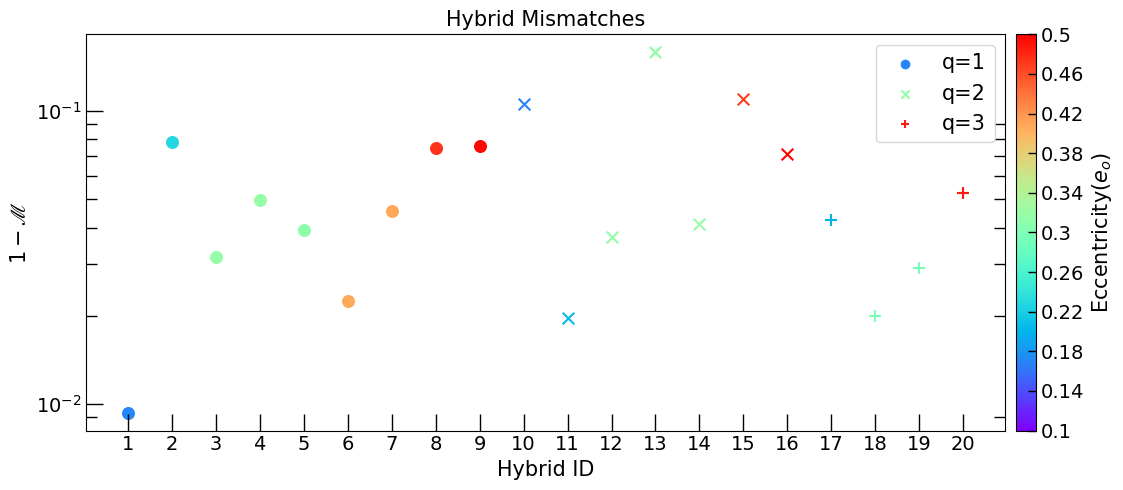

In [12]:
plt.figure(figsize=(12,5))
ID = np.arange(1,21,1)

binl = 0.001
N = int((0.51-0.1)/binl)
cmap = plt.get_cmap('rainbow', N)
sm = plt.cm.ScalarMappable(cmap=cmap)



plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
mpl.rcParams['xtick.major.size'] = 12
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 8
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 12
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 8
mpl.rcParams['ytick.minor.width'] = 1
plt.locator_params(axis='y',nbins=6)
plt.tick_params(axis='y',direction='in')
plt.tick_params(axis='x',direction='in')
plt.minorticks_on()
plt.tick_params(axis='y',which='minor',direction='in',right=True)
plt.tick_params(axis='x',which='minor',bottom=False)   

for k in ID:
    if q0[k-1]==1:
        mark = marker_sty[0]
    elif q0[k-1]==2:
        mark = marker_sty[1]
    else:
        mark = marker_sty[2]
    plt.scatter(ID[k-1], Mismatch_vals[k-1],marker=mark,s=70,color=cmap(int((estr[k-1]-0.1)/binl)))
    
plt.scatter(ID[0],Mismatch_vals[0],color=cmap(int((estr[0]-0.1)/binl)),marker='o',label='q=1')
plt.scatter(ID[12],Mismatch_vals[12],color=cmap(int((estr[12]-0.1)/binl)),marker='x',label='q=2')
plt.scatter(ID[19],Mismatch_vals[19],color=cmap(int((estr[19]-0.1)/binl)),marker='+',label='q=3')


#plt.scatter(ID, tmatch_freq_Vec, marker = 'o', facecolor ='none',edgecolor='orange',s=80,label='Numerical' )

cbar = plt.colorbar(sm,pad=0.01)
tick_locator = ticker.MaxNLocator(nbins=11)
cbar.locator = tick_locator
cbar.update_ticks()

cbar.ax.set_yticklabels(tick)
cbar.set_label(label='Eccentricity$(e_o)$',size=15)
cbar.ax.tick_params(labelsize=14,width=1.5, length=5)
cbar.ax.tick_params(which="minor",width=1, length=3, direction = 'in')
cbar.ax.tick_params(which="major",width=1, length=6, direction = 'in')

plt.xticks(ID)
plt.yscale('log')
plt.xlabel('Hybrid ID',fontsize=15)
plt.ylabel(r'$1-\mathscr{M}$',fontsize=15)
plt.title('Hybrid Mismatches',fontsize=15)
plt.tight_layout()


plt.legend(fontsize=15)

plt.show()
#plt.savefig('/home/pratul/Downloads/Project/Plots_draft/Hybrid_match_plot_40MSun.pdf',dpi=300)

# $h_p$ comparison 

In [9]:
f = h5py.File('/home/pratul/Downloads/Project/New hybrids/1371_EccTD_22_hyb_poster.h5','r')
f1 = h5py.File('/home/pratul/Downloads/Project/hybrids/1371hyb_EccTD_xlow045_GM.h5','r')
d = f['l2_m2']
d1 = f1['l2_m2']
#d = f['OutermostExtraction.dir']['Y_l2_m2.dat']
#x1 = np.real(d[:,0])
#plotband=np.where(x1>=170)
tVec = real(d[:,0])
h22pVec = real(d[0:,1])
h22cVec = real(d[0:,2])

tVec1 = real(d1[:,0])
h22pVec1 = real(d1[0:,1])
h22cVec1 = real(d1[0:,2])

mode2polfac=4*(5/(64*np.pi))**(1/2)
hpVec=h22pVec
hcVec=h22cVec

hpVec1=h22pVec1
hcVec1=h22cVec1

tVec = tVec - tVec[np.argmax(abs(hpVec + 1j*hcVec))]
tVec1 = tVec1 - tVec1[np.argmax(abs(hpVec1 + 1j*hcVec1))]


M=30
M_SI=M*MSUN_SI
D_SI=(10**(6))*PC_SI
hpVec=hpVec*G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac
hcVec=hcVec*G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac
hpVec1=hpVec1*G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac
hcVec1=hcVec1*G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac

amp = abs(hpVec+1j*hcVec)
amp1 = abs(hpVec1+1j*hcVec1)

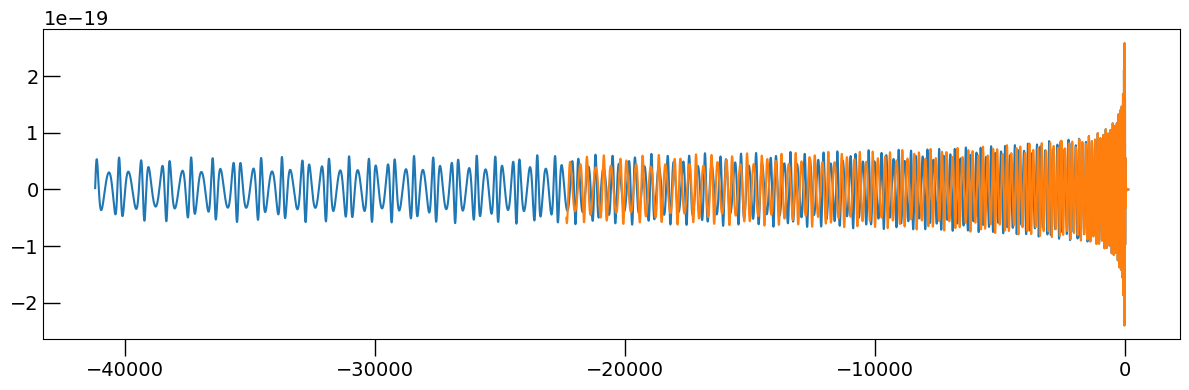

In [10]:
plt.figure(figsize=(12,4))
#plt.xlim(tVec1[0],10)
plt.plot(tVec,hpVec)
plt.plot(tVec1,hpVec1)

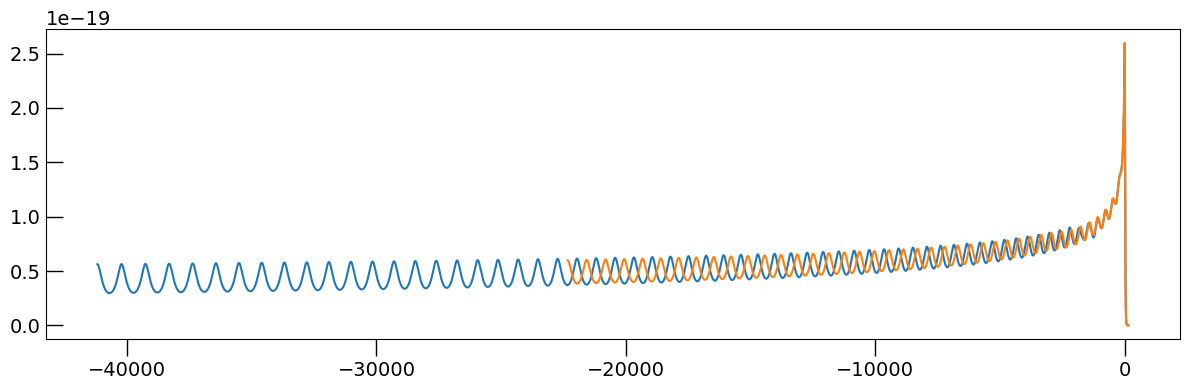

In [11]:
plt.figure(figsize=(12,4))
plt.plot(tVec,amp)
plt.plot(tVec1,amp1)

### Master Bib modification 

In [ ]:
import quick_bib
import bibtexparser

In [ ]:
quick_bib.remove_repeats_from_file_to_new('bib_files/master.bib', 'bib_files/EccPNNRHigherModes.bib')

In [ ]:
quick_bib.check_missing_arxiv_in_file('bib_files/master.bib')

In [ ]:
quick_bib.remove_repeats_from_file('bib_files/Chattaraj_etal_2022a.bib')

In [ ]:
quick_bib.check_if_repeats_in_file('bib_files/master.bib')

In [ ]:
quick_bib.merge_two_files_to_new('bib_files/master_refs_updated.bib','bib_files/master.bib','bib_files/Chattaraj_etal_2022a.bib')